## DTSA5509: Introduction to Machine Learning
### Final Project, 2023-08-21


### Problem Description:

I found the NASA Planetary Systems dataset on Kaggle, which is *'an extensive online repository managed by the NASA Exoplanet Science Institute as a part of the California Institute of Technology. It provides a comprehensive and accessible catalog of data on exoplanets and their host stars, including discovery methods, orbital parameters, and stellar characteristics'*.

Given that stargazing has been around for thousands of years, I was curious if there were specific exoplanet features that may be correlated to discovery year. A simple example would be that large, bright, near stars & corresponding planets were most likely discovered soonest, and as technology has progressed, we've started looking farther and have found previously unknown exoplanets.

$\underline{\text{About the Planetary Systems Composite Data:}}$

'The Planetary Systems Composite Parameters Planet Data table (PSCompPars) is a compilation of system, stellar, and planetary parameters for known Confirmed Exoplanets. The purpose of this table is to enable a more statistical view of the known exoplanet population and their host environments.'

I am choosing the composite data, rather than the planetary systems dataset, as the composite table includes only one row per exoplanet, defaulting to a single reference, rather than listing each reference's data separately.

The definitions of the columns can be found on the CalTech website [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html), and the source data can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/kaggleprollc/planetary-systems-dataset-nasa) or on the CalTech website [here](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars).


### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
## Get data

# Composite dataset
nasa_comp = pd.read_csv('C:/Users/kathe/OneDrive/MS-DS/DTSA5509 - Intro to ML/Final Project/NASA_Exoplanet_Composite.csv',
                   sep = ',', low_memory = False)

In [3]:
nasa_comp.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,...,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2.0,1,2,0,0,0
1,2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.0,1,1,0,0,0
2,3,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.0,1,1,0,0,0
3,4,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,1,2,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.0,1,4,1,0,0
4,5,16 Cyg B b,16 Cyg B,b,HD 186427,HIP 96901,TIC 27533327,Gaia DR2 2135550755683407232,3,1,...,6.095,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5.0,1,4,3,0,0



**Column Selection**

I am mostly interested in the Planetary and Stellar parameters, so I will grab a subset of the features related to the exoplanet (columns like 'pl%'), stellar data (columns like 'st%'), plus general identifying and discovery information.

I am removing columns related to uncertainty, links, and references, as I will be focusing on the variable & categorical data itself.

In [4]:
## Select columns related to:
    # ^sy_.*num.* - system composition
    # ^sy_.*dist.* - distance of system
    # name - name of planet
    # disc - planet discovery
    # starts with pl - planet parameters
    # starts with st - stellar parameters
    # flag - catch all for interesting columns, may subset later

nasa_planets = nasa_comp.loc[:, (nasa_comp.columns.str.contains('name|disc|flag') | 
                                 nasa_comp.columns.str.contains(r'^sy_.*num.*$', regex = True) |
                                 nasa_comp.columns.str.contains(r'^sy_.*dist.*$', regex = True) |
                                nasa_comp.columns.str.startswith('pl')|
                                nasa_comp.columns.str.startswith('st'))]


## Get rid of the uncertainties columns, just going to look at overall concepts
nasa_planets = nasa_planets.loc[:, ~nasa_planets.columns.str.contains('err')]

## Also take out links and references
nasa_planets = nasa_planets.loc[:, ~nasa_planets.columns.str.contains('link')]
nasa_planets = nasa_planets.loc[:, ~nasa_planets.columns.str.contains('ref')]

nasa_planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5483 entries, 0 to 5482
Columns: 106 entries, pl_name to pl_ntranspec
dtypes: float64(70), int64(22), object(14)
memory usage: 4.4+ MB


Even selecting a subset of the Planetary Composite data results in 106 columns. I am going to look for columns with $>10\%$ null values, and remove those features from the analysis.

In [5]:
## Get null counts greater than 10%

col_null_percent = []
cols_to_drop = []
for c in nasa_planets.columns:
    if nasa_planets[c].isnull().sum() > 0:
        if nasa_planets[c].isnull().sum()/nasa_planets.shape[0] > 0.1:
            cols_to_drop.append(c)
            col_null_percent.append(nasa_planets[c].isnull().sum()/nasa_planets.shape[0])
        
cols_to_drop

['hd_name',
 'hip_name',
 'pl_orbeccen',
 'pl_orbeccenlim',
 'pl_insol',
 'pl_insollim',
 'pl_eqt',
 'pl_eqtlim',
 'pl_orbincl',
 'pl_orbincllim',
 'pl_tranmid',
 'pl_tranmidlim',
 'pl_imppar',
 'pl_impparlim',
 'pl_trandep',
 'pl_trandeplim',
 'pl_trandur',
 'pl_trandurlim',
 'pl_ratdor',
 'pl_ratdorlim',
 'pl_ratror',
 'pl_ratrorlim',
 'pl_occdep',
 'pl_occdeplim',
 'pl_orbtper',
 'pl_orbtperlim',
 'pl_orblper',
 'pl_orblperlim',
 'pl_rvamp',
 'pl_rvamplim',
 'pl_projobliq',
 'pl_projobliqlim',
 'pl_trueobliq',
 'pl_trueobliqlim',
 'st_spectype',
 'st_age',
 'st_agelim',
 'st_vsin',
 'st_vsinlim',
 'st_rotp',
 'st_rotplim',
 'st_radv',
 'st_radvlim']

In [6]:
# Drop columns with greater than 10% null values
nasa_planets = nasa_planets.drop(cols_to_drop, axis = 1)

nasa_planets.shape

(5483, 63)

Now there are 63 columns remaining. Since I am predominately interested in discovery year, below is a histogram of exoplanet discoveries vs. year.


[Text(0.5, 1.0, 'Histogram of Exoplanet Discovery Years'),
 Text(0.5, 0, 'Discovery Year'),
 Text(0, 0.5, 'Count of Exoplanets')]

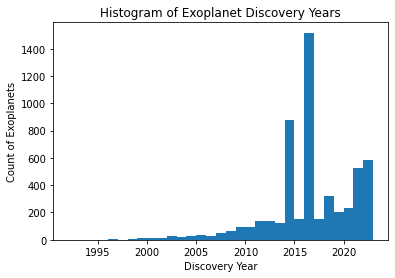

In [7]:
# I want to see the range of discovery dates included

min_year = nasa_planets['disc_year'].min()
max_year = nasa_planets['disc_year'].max()

fig, ax = plt.subplots()

# I want to show each year as it's own bar
ax.hist(nasa_planets['disc_year'], bins = max_year - min_year)

ax.set(title = 'Histogram of Exoplanet Discovery Years',
      xlabel = 'Discovery Year',
      ylabel = 'Count of Exoplanets')


It is interesting that 2014 and 2016 show such a large number of discoveries outside of the general upward trend.

To see what variables may be related to the high discovery counts in 2014 and 2016, I sliced the data to discovery years 2013 through 2016 and created histograms of the discovery columns, showing the density of each level within the factor.

In the plots below, it appears that 2014 and 2016 discoveries tended to used the transit detection method rather than radial velocity for 2013 and 2015. Additionally, a much larger proportion of exoplanets were discovered in space for 14 and 16, vs. a lot of ground-based findings in 13 and 15.

Perhaps there was additional space exploration missions in these two years, leading to the above expected discovery counts.

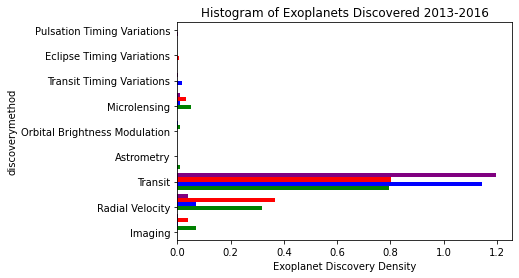

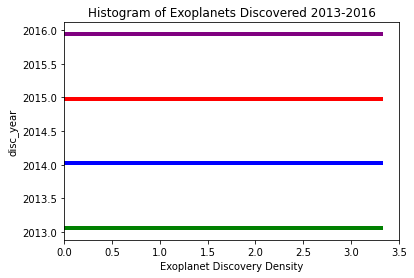

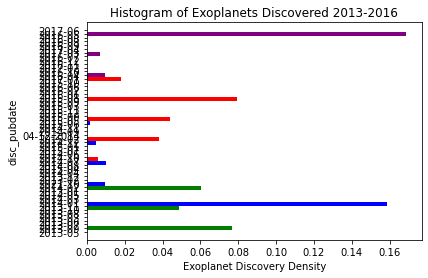

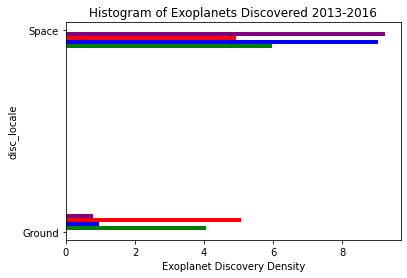

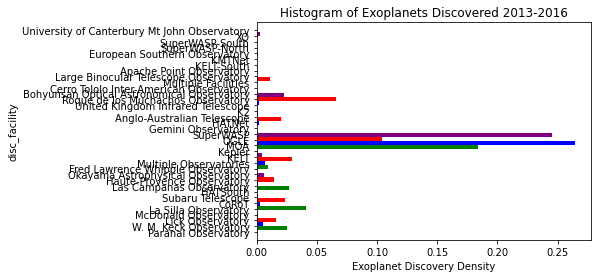

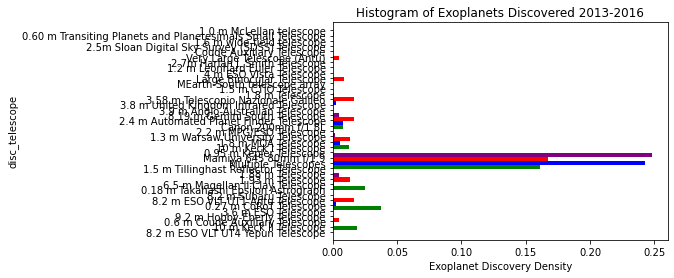

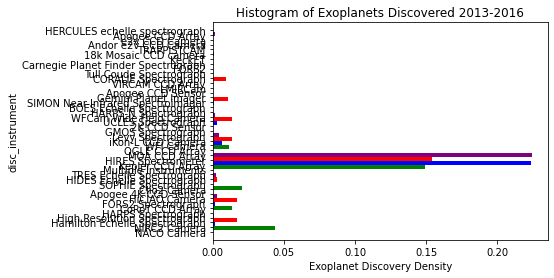

In [8]:
## Look at histograms of discovery info for 2013 through 2016 planets
nasa_13to16 = nasa_planets.query('disc_year >= 2014 & disc_year <= 2016')

disc_colnames = nasa_planets.loc[:, nasa_planets.columns.str.contains('disc')].columns


for elt in disc_colnames:
    fig, ax = plt.subplots()
    
    df13 = nasa_planets.query('disc_year == 2013').loc[:,elt]
    df14 = nasa_planets.query('disc_year == 2014').loc[:,elt]
    df15 = nasa_planets.query('disc_year == 2015').loc[:,elt]
    df16 = nasa_planets.query('disc_year == 2016').loc[:,elt]
    
    plt.hist([df13, df14, df15, df16], color = ['green','blue','red','purple'], orientation = 'horizontal', density = True)
    ax.set(title = 'Histogram of Exoplanets Discovered 2013-2016',
      ylabel = elt,
      xlabel = 'Exoplanet Discovery Density')
    plt.show()

**Correlation Analysis*

After finding interesting differences in the discovery metadata vs. discovery year, I decided to look at the correlation between each variable in the full dataset and discovery year. Due to the large number of columns, I printed only the correlation coefficients against disc_year. I will be taking a look at correlation between covariates later in the analysis, before building a model.

Based on the correlation coefficients below, the highest positive correlation is tran_flag (Detected by Transits) at 0.2065, while the strongest negative correlation is st_nrvc (Number of Radial Velocity Time Series) at -0.5215.

Tran_flag is not surprising given it's importance in the analysis above. Additionally, st_nvrc is the 'Number of literature radial velocity curves available for this star in the NASA Exoplanet Archive'. This likely means that the more a star has been studied, the earlier it was discovered.

In [9]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(nasa_planets.corr(min_periods = 100)['disc_year'].sort_values(ascending = False))

## Most positively correlated is pl_tranmid at 0.4399
    # "Transit Midpoint" The time given by the average of the time the planet begins to cross the stellar limb and 
    # the time the planet finishes crossing the stellar limb.
## Followed by tran_flag at 0.2065
    # Detected by transits
## Most negatively correlated are pl_radj and pl_rade at roughly -0.23 (planet radius in terms of Jupiter, Earth)
## Next negative correlated is rv_flag: Detections by Radial Velocity Variations


## Based on these correlations, it appears that radial velocity findings are going down, and transits findings are going up. We are 
## starting to find smaller exoplanets as the years go on (makes sense)

disc_year          1.000e+00
tran_flag          2.065e-01
st_logg            1.236e-01
sy_dist            1.225e-01
micro_flag         1.198e-01
st_dens            5.933e-02
pl_denslim         2.755e-02
pl_orbper          1.556e-02
dkin_flag          8.970e-03
pl_orbsmax         9.810e-04
pl_orbsmaxlim     -2.608e-03
pl_bmasselim      -3.757e-03
pl_bmassjlim      -3.757e-03
pl_orbperlim      -1.125e-02
pl_dens           -1.298e-02
st_tefflim        -1.552e-02
etv_flag          -1.624e-02
pl_radjlim        -1.794e-02
pl_radelim        -1.795e-02
ptv_flag          -1.945e-02
pl_bmasse         -1.959e-02
pl_bmassj         -1.961e-02
st_logglim        -2.686e-02
cb_flag           -2.937e-02
pl_nespec         -2.998e-02
pl_controv_flag   -3.054e-02
st_metlim         -3.297e-02
ima_flag          -4.583e-02
pl_ntranspec      -4.870e-02
st_rad            -5.284e-02
st_teff           -6.424e-02
ast_flag          -8.154e-02
st_met            -8.294e-02
obm_flag          -9.034e-02
pul_flag      

To help show the highest correlated variables, included below is a plot of discovery year against each feature with $abs(corr) \geq 0.1$

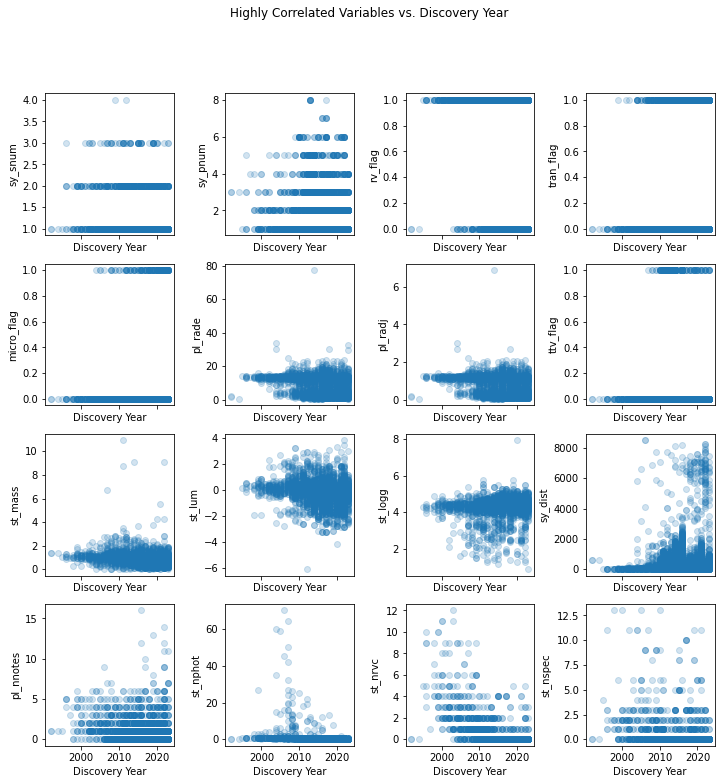

In [10]:
## Create plots of highly correlated variables (>0.1 or <-0.1) vs. disc year

corrs = nasa_planets.corr(min_periods = 100)['disc_year']

corrs = pd.DataFrame(data = corrs)

corrs.columns = ['correlation']

highly_corr = list(corrs[(corrs.correlation > 0.1) | (corrs.correlation < -0.1)].index)

highly_corr.remove('disc_year')

fig, axes = plt.subplots(4,4,figsize=(12, 12), sharex = True)

for row in range(4):
    for col in range(4):
        ax = axes[row, col]
        index = col+(row*4)
        elt = highly_corr[index]
        ax.set(xlabel = 'Discovery Year',
               ylabel = elt)
        ax.scatter(nasa_planets['disc_year'], nasa_planets[elt], alpha = 0.2)
        #ax.show()

plt.subplots_adjust(wspace= 0.4)        
plt.suptitle("Highly Correlated Variables vs. Discovery Year")
plt.show()

### Summary of Findings: EDA

2014 and 2016 seem to have had a disproportionate number of exoplanet discoveries, with a higher percentage of findings made in space (particularly with Kepler telescopes) rather than on the ground. Additionally, more exoplanets seem to be getting discovered via transit rather than radial velocity variations. 

As you would expect, exoplanet radius is negatively correlated with discovery year, meaning as technology improves, we are generally able to find smaller planets. Additionally, the number of radial velocity time series is negatively correlated with discovery year, suggesting older systems have been studied more broadly. Lastly, system distance from earth increases with discovery year.


### Model Building and Training

**Method Overview:**

Using the findings above, I am going to limit the number of features to model on by removing columns that contain identifying information with respect to the discovery year, as well as columns that resulted in NaN correlation coefficients. 

I will then assess correlation between the remaining features, and limit these relationships to avoid collinearity. With the resulting dataset, I will leave the categorical variables as-is but perform min-max scaling on the numeric columns. 

Finally, I will use forward selection to additively create a model up to 10 features. Training will be performed on 80% of the data, then testing with the remaining 20%.

In [11]:
## Remove columns with giveaway information w.r.t year
columns_to_remove = ['sy_mnum','disc_pubdate','pl_nnotes','disc_year']

lim_cols = list(nasa_planets.loc[:,nasa_planets.columns.str.contains('lim')].columns)
name_cols = list(nasa_planets.loc[:,nasa_planets.columns.str.contains('name')].columns)

columns_to_remove.extend(lim_cols)
columns_to_remove.extend(name_cols)

columns_to_remove = pd.Series(columns_to_remove).unique()

columns_to_model = nasa_planets.columns.difference(columns_to_remove)

#columns_to_model # looks good

In [12]:
## first I want to see if any of the columns to model are highly correlated with one another. If so, need to reduce

corr_matrix = nasa_planets.loc[:,nasa_planets.columns.difference(columns_to_remove)].corr()

mask = ((corr_matrix > 0.7) & (corr_matrix < 1)) | ((corr_matrix < -0.7) & (corr_matrix > -1))

# Get the row and column indices where the mask is True
rows, cols = np.where(mask)

# Create a list of row-column pairs with correlation coefficients
correlation_pairs = [(corr_matrix.index[rows[i]], corr_matrix.columns[cols[i]]) for i in range(len(rows))]


# Print the correlation pairs
for pair in correlation_pairs:
    print(pair)

('micro_flag', 'sy_dist')
('pl_bmasse', 'pl_bmassj')
('pl_bmassj', 'pl_bmasse')
('pl_orbper', 'pl_orbsmax')
('pl_orbsmax', 'pl_orbper')
('pl_rade', 'pl_radj')
('pl_radj', 'pl_rade')
('st_logg', 'st_lum')
('st_logg', 'st_rad')
('st_lum', 'st_logg')
('st_lum', 'st_mass')
('st_mass', 'st_lum')
('st_rad', 'st_logg')
('sy_dist', 'micro_flag')


**Correlated Column Reduction:**

14 pairs, but reverse directions, so 7 relationships to consider:

st_logg 'Stellar Surface Gravity'
    - Correlated with:
        - st_lum, 'Stellar Luminosity'
        - st_rad, 'Stellar Radius'
    - *st_logg* is the most correlated with disc_year
    
st_lum, 'Stellar Luminosity':
    - Correlated with:
        - st_logg 'Stellar Surface Gravity'
        - st_mass, 'Stellar Mass'
    - *st_lum* is the most correlated with disc_year

pl_orbsmax, 'Orbit Semi-Major Axis': 
    - Correlated with:
        - pl_orbper: Orbital Period
    - *pl_orbper* is the most correlated with disc_year

pl_bmasse, mass measurements with respect to Earth
    - Correlated with:
        - pl_bmassj: mass measurements with respect to Jupiter
    - *pl_bmasse*, best to work scaled to Earth
    
pl_rade, radius measurements with respect to Earth
    - Correlated with:
        - pl_radj: radius measurements with respect to Jupiter
    - *pl_rade*, best to work scaled to Earth

sy_dist, system distance from Earth: 
    - Correlated with:
        - micro_flag: detection by microlensing
    - *sy_dist* is a continous variable and better correlated to disc_year
        
        
Based upon these correlations, we can limit the highly correlated columns to model on to st_logg, st_lum, pl_orbper, pl_bmasse, pl_rade, and sy_dist, 
thereby removing pl_orbsmax, pl_bmassj, pl_radj, micro_flag, st_rad, and st_mass from the columns to model.

In [13]:
## Extend removal columns

columns_to_remove = list(columns_to_remove)

columns_to_remove.extend(['pl_orbsmax', 'pl_bmassj', 'pl_radj', 'micro_flag', 'st_rad', 'st_mass'])

In [14]:
## Columns to consider in the model are those not in the list 'columns_to_remove'
columns_to_model = list(nasa_planets.columns.difference(columns_to_remove))

**Scale and Finalize Data for Modeling**

In [15]:
### Normalize data

# I am going to use min-max normalization with the sklearn function preprocessing.MinMaxScaler()
# I am choosing to normalize on a 0 to 1 scale
all_mod_cols = columns_to_model.copy()

all_mod_cols.extend(['disc_year'])  # will scale disc year as well

# Create a copy of all columns 
cols_to_scale = all_mod_cols.copy()


## Get only numeric columns
for col in all_mod_cols:
    if nasa_planets[col].dtype == 'O':
        cols_to_scale.remove(col)


scaler = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(nasa_planets.loc[:,cols_to_scale])

scaled_data = pd.DataFrame(data = scaler.transform(nasa_planets.loc[:,cols_to_scale]), columns = cols_to_scale)

cat_cols = list(nasa_planets.loc[:,all_mod_cols].columns.difference(cols_to_scale))

# I only want discovery categories included
cat_cols = [column for column in cat_cols if 'disc' in column]

data_to_model = pd.concat([scaled_data, nasa_planets.loc[:,cat_cols]], axis = 'columns')

data_to_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5483 entries, 0 to 5482
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ast_flag         5483 non-null   float64
 1   cb_flag          5483 non-null   float64
 2   dkin_flag        5483 non-null   float64
 3   etv_flag         5483 non-null   float64
 4   ima_flag         5483 non-null   float64
 5   obm_flag         5483 non-null   float64
 6   pl_bmasse        5458 non-null   float64
 7   pl_controv_flag  5483 non-null   float64
 8   pl_dens          5374 non-null   float64
 9   pl_nespec        5483 non-null   float64
 10  pl_ntranspec     5483 non-null   float64
 11  pl_orbper        5244 non-null   float64
 12  pl_rade          5465 non-null   float64
 13  ptv_flag         5483 non-null   float64
 14  pul_flag         5483 non-null   float64
 15  rv_flag          5483 non-null   float64
 16  st_dens          4998 non-null   float64
 17  st_logg       

**Split Modeling Data into Training & Test Sets**

In [16]:
## Use forward selection on columns in model

train_planets, test_planets = train_test_split(data_to_model, test_size=0.2, random_state=0)

columns_to_model_final = list(train_planets.columns.drop('disc_year'))

**Perform Forward Stepwise Selection to k = 10 Features**

In [17]:
# Find the first best feature by maximizing adjusted R-squared
best = ['',0]
param_fits = []
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~'+col, data=train_planets).fit()
    param_fits.append((col, model.rsquared_adj))
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best[1]:
        best = [col, model.rsquared_adj]
print('best:',best)

ast_flag 0.0036596142633603668
cb_flag 0.0006767165079781812
dkin_flag -0.0001285853298169659
etv_flag 4.864293031847655e-05
ima_flag 0.0011115463155683125
obm_flag 0.005524074040056837
pl_bmasse 0.00048562543627694854
pl_controv_flag 0.0008622012145350633
pl_dens -5.290351718922892e-07
pl_nespec 0.006024941336109646
pl_ntranspec 0.0021428746096432416
pl_orbper 6.26345626369984e-05
pl_rade 0.05190702053648433
ptv_flag 0.0002522642818039156
pul_flag 0.009027802109555783
rv_flag 0.03559756441923201
st_dens 0.0030193711145750646
st_logg 0.01688240623060322
st_lum 0.022285190627851503
st_met 0.0056926744365847215
st_nphot 0.04776786502071062
st_nrvc 0.27299854609016405
st_nspec 0.051570512471927676
st_teff 0.004331270446812807
sy_dist 0.014045147343470843
sy_pnum 0.011970541121052336
sy_snum 0.027614858676264897
tran_flag 0.03759626993681209
ttv_flag 0.01168036210588097
disc_facility 0.38063021120295826
disc_instrument 0.41474959200997163
disc_locale 0.06108616967487934
disc_telescope 0.38

In [18]:
columns_to_model_final.remove('disc_instrument')

## Find the next best feature

best2 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best2[1]:
        best2 = [col, model.rsquared_adj]
print('best2:',best2)


ast_flag 0.41829677868369886
cb_flag 0.4155531879125096
dkin_flag 0.4147495920099722
etv_flag 0.41530905890849623
ima_flag 0.41553944117293784
obm_flag 0.41774226574229256
pl_bmasse 0.41582309054793753
pl_controv_flag 0.4147694525174441
pl_dens 0.4172267190313883
pl_nespec 0.4161701023009947
pl_ntranspec 0.4150052818183888
pl_orbper 0.41486469162591444
pl_rade 0.41923932042162415
ptv_flag 0.41533957606376903
pul_flag 0.4146206114063409
rv_flag 0.42047592834674397
st_dens 0.43484074260607775
st_logg 0.4125627991687931
st_lum 0.4136484093025864
st_met 0.40571331072989636
st_nphot 0.4298759388996437
st_nrvc 0.5314493796228297
st_nspec 0.4299199593253309
st_teff 0.4148219762977543
sy_dist 0.4142101600678637
sy_pnum 0.4336756686446832
sy_snum 0.42328009850190584
tran_flag 0.4157271244877868
ttv_flag 0.4339122873504998
disc_facility 0.44218688711282494
disc_locale 0.4153523879847434
disc_telescope 0.4178248115845682
discoverymethod 0.4253434658408525
best2: ['st_nrvc', 0.5314493796228297]


In [19]:
# Remove the best fitting parameter
columns_to_model_final.remove('st_nrvc')

## Find the next best feature
best3 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best3[1]:
        best3 = [col, model.rsquared_adj]
print('best3:',best3)

ast_flag 0.5322304194610552
cb_flag 0.5329711634028041
dkin_flag 0.5314493796228295
etv_flag 0.5328143295594339
ima_flag 0.5314312367848291
obm_flag 0.5329762713624157
pl_bmasse 0.532601682946281
pl_controv_flag 0.5316062597955672
pl_dens 0.5349014067120472
pl_nespec 0.5322442368621945
pl_ntranspec 0.5313901178656306
pl_orbper 0.5333412357068649
pl_rade 0.5349042576341478
ptv_flag 0.5322686863698055
pul_flag 0.5313976137534586
rv_flag 0.5342877900872185
st_dens 0.5377487507894192
st_logg 0.5302219122331995
st_lum 0.5322762290173226
st_met 0.5261794772134294
st_nphot 0.5348845151592359
st_nspec 0.5313412239797419
st_teff 0.5329792805223603
sy_dist 0.5306010190767763
sy_pnum 0.544370126182363
sy_snum 0.5355228284945617
tran_flag 0.5316989070498177
ttv_flag 0.5500985555773348
disc_facility 0.5525280263983754
disc_locale 0.5313005072615169
disc_telescope 0.5309048572067561
discoverymethod 0.5385096099664717
best3: ['disc_facility', 0.5525280263983754]


In [20]:
# Remove the best fitting parameter
columns_to_model_final.remove('disc_facility')

## Find the next best feature
best4 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best4[1]:
        best4 = [col, model.rsquared_adj]
print('best4:',best4)

ast_flag 0.5538760059440191
cb_flag 0.5558959442056639
dkin_flag 0.5523517423484099
etv_flag 0.5434406449362597
ima_flag 0.5526826092807342
obm_flag 0.5506846849826557
pl_bmasse 0.5557227453380154
pl_controv_flag 0.5536020490896567
pl_dens 0.5533998984821925
pl_nespec 0.5482472907192262
pl_ntranspec 0.5527738381147337
pl_orbper 0.5580504750182151
pl_rade 0.5569860667602733
ptv_flag 0.5534886053883308
pul_flag 0.5542574249548293
rv_flag 0.5535261475816682
st_dens 0.5653727105247396
st_logg 0.5554633985760049
st_lum 0.5557941303015994
st_met 0.5520410500961483
st_nphot 0.5576938579087273
st_nspec 0.554371027837044
st_teff 0.5559915379671134
sy_dist 0.5561461934301665
sy_pnum 0.5662852590088391
sy_snum 0.5510649526440359
tran_flag 0.554675439790745
ttv_flag 0.5697260393594584
disc_locale 0.5545751079495704
disc_telescope 0.5288526632217971
discoverymethod 0.5600550180806398
best4: ['ttv_flag', 0.5697260393594584]


In [21]:
# Remove the best fitting parameter
columns_to_model_final.remove('ttv_flag')

## Find the next best feature
best5 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best5[1]:
        best5 = [col, model.rsquared_adj]
print('best5:',best5)

ast_flag 0.5704065447407686
cb_flag 0.5699862146084025
dkin_flag 0.5693708918750411
etv_flag 0.5713858119147075
ima_flag 0.5696574037105644
obm_flag 0.5709484752250396
pl_bmasse 0.571341403911972
pl_controv_flag 0.5697203427052044
pl_dens 0.5701927213179931
pl_nespec 0.5703871229297774
pl_ntranspec 0.5691931592230608
pl_orbper 0.5743055455312154
pl_rade 0.5727374046674476
ptv_flag 0.5703193922266043
pul_flag 0.5698462824400791
rv_flag 0.5739044647720025
st_dens 0.5837086883302696
st_logg 0.5721767580404001
st_lum 0.5733546010549141
st_met 0.568748430810671
st_nphot 0.5720445456789314
st_nspec 0.5680976840023433
st_teff 0.5707919186508071
sy_dist 0.570097970336057
sy_pnum 0.5771297432187643
sy_snum 0.5731098035278075
tran_flag 0.5694993666042685
disc_locale 0.5679160206005263
disc_telescope 0.5651015545103182
discoverymethod 0.5760527892376806
best5: ['st_dens', 0.5837086883302696]


In [22]:
# Remove the best fitting parameter
columns_to_model_final.remove('st_dens')

## Find the next best feature
best6 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best6[1]:
        best6 = [col, model.rsquared_adj]
print('best6:',best6)

ast_flag 0.5846158563444592
cb_flag 0.5839643765923578
dkin_flag 0.5835792833381338
etv_flag 0.5838605471859566
ima_flag 0.5841448442115089
obm_flag 0.5849319559785475
pl_bmasse 0.5846320063478255
pl_controv_flag 0.583710615395192
pl_dens 0.5817284202116004
pl_nespec 0.5847782114654769
pl_ntranspec 0.583579293291141
pl_orbper 0.584202446633022
pl_rade 0.5818761886185264
ptv_flag 0.5844493293338304
pul_flag 0.583687795196919
rv_flag 0.5880425907853575
st_logg 0.5837221237432056
st_lum 0.5834240762071994
st_met 0.5819572004458817
st_nphot 0.5843717142128649
st_nspec 0.5837621572614372
st_teff 0.5846017528416966
sy_dist 0.5843542322635815
sy_pnum 0.59313204062311
sy_snum 0.5857847211844803
tran_flag 0.5837593807347663
disc_locale 0.5831668150058289
disc_telescope 0.5846840382583844
discoverymethod 0.5850137238337032
best6: ['sy_pnum', 0.59313204062311]


In [23]:
# Remove the best fitting parameter
columns_to_model_final.remove('sy_pnum')

## Find the next best feature
best7 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best7[1]:
        best7 = [col, model.rsquared_adj]
print('best7:',best7)

ast_flag 0.5926617506145344
cb_flag 0.5935920418887423
dkin_flag 0.5930961767397274
etv_flag 0.5923924985006715
ima_flag 0.593660508330921
obm_flag 0.5943228619234353
pl_bmasse 0.5939505175355959
pl_controv_flag 0.592434074379041
pl_dens 0.5901465137712836
pl_nespec 0.594117192661612
pl_ntranspec 0.5924793851964774
pl_orbper 0.5934310214930828
pl_rade 0.594042732813465
ptv_flag 0.5938926144840175
pul_flag 0.592759230675491
rv_flag 0.5971110183236026
st_logg 0.5931650114691898
st_lum 0.5930730828354309
st_met 0.592614718480371
st_nphot 0.5935822711962317
st_nspec 0.5920787915367627
st_teff 0.59418312663801
sy_dist 0.5931801245574297
sy_snum 0.5945800225778985
tran_flag 0.5931839955849805
disc_locale 0.5932515332371002
disc_telescope 0.5929599457993123
discoverymethod 0.5902517076750369
best7: ['rv_flag', 0.5971110183236026]


In [24]:
# Remove the best fitting parameter
columns_to_model_final.remove('rv_flag')

## Find the next best feature
best8 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best8[1]:
        best8 = [col, model.rsquared_adj]
print('best8:',best8)

ast_flag 0.5973772176829366
cb_flag 0.596902015255373
dkin_flag 0.596523208926907
etv_flag 0.5970117811119742
ima_flag 0.5979212802718847
obm_flag 0.5975293257198546
pl_bmasse 0.5978182770841098
pl_controv_flag 0.5968851501089663
pl_dens 0.5946032637215486
pl_nespec 0.5982065648018775
pl_ntranspec 0.5969134300635709
pl_orbper 0.5975836000389922
pl_rade 0.5974848858985156
ptv_flag 0.5982545719075965
pul_flag 0.5969512705204445
st_logg 0.5969867683702459
st_lum 0.59586428100677
st_met 0.5967086904863339
st_nphot 0.5975139129011792
st_nspec 0.5970687081991676
st_teff 0.5982264379754019
sy_dist 0.5976069607467431
sy_snum 0.5983903174555835
tran_flag 0.5964920143621703
disc_locale 0.5970703758447395
disc_telescope 0.5958711350620836
discoverymethod 0.5995151744534601
best8: ['discoverymethod', 0.5995151744534601]


In [25]:
# Remove the best fitting parameter
columns_to_model_final.remove('discoverymethod')

## Find the next best feature
best9 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best9[1]:
        best9 = [col, model.rsquared_adj]
print('best9:',best9)

ast_flag 0.6001746145663467
cb_flag 0.5995313111114453
dkin_flag 0.5995151744534601
etv_flag 0.5994479181826748
ima_flag 0.5996190267700665
obm_flag 0.6007618626096471
pl_bmasse 0.5999851281443549
pl_controv_flag 0.5994622957952956
pl_dens 0.5969550802423768
pl_nespec 0.6007084253298534
pl_ntranspec 0.5994246526660174
pl_orbper 0.5993334116552425
pl_rade 0.5996009166473737
ptv_flag 0.5995151744534601
pul_flag 0.5995151744534601
st_logg 0.5999728254322407
st_lum 0.5994224166989842
st_met 0.5987350951078467
st_nphot 0.6003130831797856
st_nspec 0.5994949400234924
st_teff 0.599975384356206
sy_dist 0.5999870639910282
sy_snum 0.6005899397541739
tran_flag 0.5994776633267285
disc_locale 0.5995017521165349
disc_telescope 0.6003036978678467
best9: ['obm_flag', 0.6007618626096471]


In [26]:
# Remove the best fitting parameter
columns_to_model_final.remove('obm_flag')

## Find the next best feature
best10 = ['',0]
for col in columns_to_model_final:
    model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag+'+col, data=train_planets).fit()
    print(col, model.rsquared_adj)
    if model.rsquared_adj>best10[1]:
        best10 = [col, model.rsquared_adj]
print('best10:',best10)

ast_flag 0.6013731195780343
cb_flag 0.6007832220353956
dkin_flag 0.6006944650887237
etv_flag 0.6005739090833879
ima_flag 0.6008565959930279
pl_bmasse 0.599676626973496
pl_controv_flag 0.6006322986781503
pl_dens 0.5982237671056698
pl_nespec 0.6010941147329452
pl_ntranspec 0.600659619844791
pl_orbper 0.5998912049220243
pl_rade 0.598496949013207
ptv_flag 0.6007018631115268
pul_flag 0.6007618626096471
st_logg 0.6012791987497474
st_lum 0.6005854836818987
st_met 0.6001086116253488
st_nphot 0.6012884120522597
st_nspec 0.6007150738077145
st_teff 0.6011397480336592
sy_dist 0.6012290460876757
sy_snum 0.6017189999462772
tran_flag 0.6007089023524198
disc_locale 0.600948691909968
disc_telescope 0.6016595469425801
best10: ['sy_snum', 0.6017189999462772]


In [27]:
## final model:

final_model  = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag+sy_snum', 
                     data=train_planets).fit()

final_model.params

Intercept                                  -2.123508e+09
disc_instrument[T.18k Mosaic CCD camera]   -4.870546e+08
disc_instrument[T.2K CCD Sensor]            2.559259e+09
disc_instrument[T.6K CCD Mosaic]           -7.379788e+09
disc_instrument[T.ACS Camera]              -2.795498e+07
                                                ...     
st_dens                                    -2.462344e-02
sy_pnum                                    -8.747357e-02
rv_flag                                    -3.362885e-02
obm_flag                                   -7.533812e-02
sy_snum                                    -4.455570e-02
Length: 167, dtype: float64

### Model Results

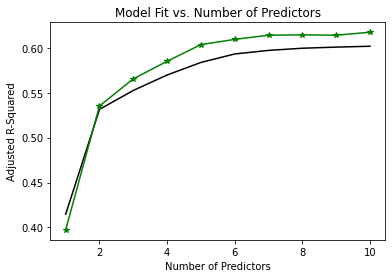

In [28]:
## Now show how R2 improves with variables

adjr2_train = [best[1], best2[1], best3[1], best4[1], best5[1],
              best6[1], best7[1], best8[1], best9[1], best10[1]]


## try out the test data
adjr2_test = [smf.ols(formula='disc_year~disc_instrument', 
                     data=test_planets).fit().rsquared_adj,
              smf.ols(formula='disc_year~disc_instrument+st_nrvc', 
                     data=test_planets).fit().rsquared_adj,
              smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility', 
                     data=test_planets).fit().rsquared_adj,
              smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag', 
                     data=test_planets).fit().rsquared_adj,
              smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens', 
                     data=test_planets).fit().rsquared_adj,
             smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum', 
                     data=test_planets).fit().rsquared_adj,
             smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag', 
                     data=test_planets).fit().rsquared_adj,
             smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod', 
                     data=test_planets).fit().rsquared_adj,
             smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag', 
                     data=test_planets).fit().rsquared_adj,
             smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag+sy_snum', 
                     data=test_planets).fit().rsquared_adj]


x = range(1,11)

fig, ax = plt.subplots()
plt.plot(x, adjr2_train, color = 'black')
plt.plot(x, adjr2_test, marker = '*', color = 'green')
plt.xlabel("Number of Predictors")
plt.ylabel("Adjusted R-Squared")
plt.title("Model Fit vs. Number of Predictors")


plt.show()

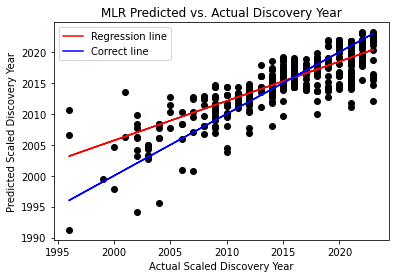

In [29]:
## Let's plot the predicted year vs. actual year for the test data

test_planets = test_planets.dropna()

x = test_planets['disc_year']*(max_year - min_year) + min_year

preds = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag+sy_snum', 
                     data=test_planets).fit().predict()

y = (preds*(max_year - min_year) + min_year)


fig, ax = plt.subplots()
plt.scatter(x, y, color = 'black')

# Fit a linear regression line using numpy's polyfit
coefficients = np.polyfit(x, y, 1)
line = np.polyval(coefficients, x)

correct_line = np.polyval(np.polyfit(x, x, 1), x)

# Plot the regression line
plt.plot(x, line, color='red', label='Regression line')
plt.plot(x, correct_line, color='blue', label='Correct line', linestyle = '-')
plt.legend()
ax.set(xlabel = 'Actual Scaled Discovery Year',
       ylabel = 'Predicted Scaled Discovery Year',
       title = 'MLR Predicted vs. Actual Discovery Year')

plt.show()


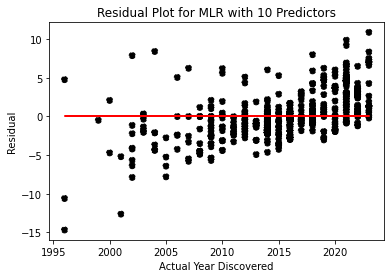

In [30]:
## Residual plot
years_orig = test_planets['disc_year']*(max_year - min_year) + min_year

preds = smf.ols(formula='disc_year~disc_instrument+st_nrvc+disc_facility+ttv_flag+st_dens+sy_pnum+rv_flag+discoverymethod+obm_flag+sy_snum', 
                     data=test_planets).fit().predict()

years_pred = years_orig - (preds*(max_year - min_year) + min_year)

fig, ax = plt.subplots()
plt.scatter(years_orig, years_pred, color = 'black', linestyle = 'dashed')
plt.plot(years_orig, np.linspace(0, 0, num = len(years_orig)), color = 'red')
ax.set(xlabel = 'Actual Year Discovered',
       ylabel = 'Residual',
       title = 'Residual Plot for MLR with 10 Predictors')
plt.show()

### Conclusion:

Performing forward stepwise selection of 10 variables resulted in a multi-linear regression model of:

$$\text{disc_year}\sim \text{disc_instrument + st_nrvc + disc_facility + ttv_flag + st_dens + sy_pnum + rv_flag + discoverymethod + obm_flag + sy_snum}$$

With column definitions as:
- disc_year: Discovery Year
- disc_instrument: Discovery Instrument
- st_nrvc: Number of Radial Velocity Time Series
- disc_facility: Discovery Facility
- ttv_flag: Data show Transit Timing Variations
- st_dens: Stellar Density
- sy_pnum: Number of Planets in System
- rv_flag: Detections by Radial Velocity Variations
- discoverymethod: Discovery Method
- obm_flag: Detected by Orbital Brightness Modulations


Several of these columns are directly related to the discovery metadata, such as location, equipment, and method. I am surprised to see that system distance was not one of the top 10 features in the model, as that was a prior assumption going into the analysis. The primary continuous variable that was selected 6th is Stellar Density, which may factor into the ability to detect a new star with one of the methods described (i.e. radial velocity, transit timing, etc.)

Overall, the final model's adjusted $R^2$ is still rather low at $\sim 60\%$. Due to the number of features and observations, I believe this model has quite a bit of bias. Reviewing the plots of predicted vs. actual discovery year, as well as the residuals plot, shows that the model systematically over-predicts the discovery years in the period prior to 2015, while under-predicting the discovery year of those after 2015.

Additional features showed marginal improvement in the adjusted $R^2$, and plotting the goodness of fit vs. number of predictors shows that this model would perform nearly the same using only 6 predictors instead of 10.

In order to improve this model in the future, subject matter expertise would be helpful in pointing towards the likely factors & technology improvements that are driving discoveries through the years.

Link to GitHub repo: https://github.com/KG-msds/DTSA5509